# Hybrid ML-Based Simulation with SDV + Rules

We’ll combine:

- ML-based synthetic models for structured data (SDV: CTGAN / TVAE)
- Rule-based logic for realistic behavior simulation

RULES :

- email should match first_name + last_name.
- loyalty_status should reflect total_spent.
- Unique customer_id, product_id, email, etc.
- Correct field formats (e.g., phone numbers, dates)
- Inter-field logic (e.g., status = 'inactive' → last_login is old)
- Enable Cross-Dataset Relationships
- Generate user_id in users.csv and assign it to interactions.csv.
- Generate product_id in products.csv and assign it to sales.csv.

In [ ]:
#STEP 0: Imports
import pandas as pd
import numpy as np
from faker import Faker
import string
from sdv.tabular import CTGAN
from datetime import datetime, timedelta
import random
from config.paths import SEED_DIR, SYNTHETIC_DIR

Clients table :

    client_id
    name
    email
    gender
    phone
    birth_date
    age
    region
    registration_date
    source: 'e-shop', 'erp', 'manual'
    loyalty_score
    loyalty_status
    total_purchases
    last_purchase_date
    is_active
    loyalty_status
    tax_number


In [ ]:
# client_id
n_clients = 200  # or any number you need
client_ids = [f"#client{idx}" for idx in range(1, n_clients + 1)]

In [ ]:
fake = Faker('fr_FR')
# Tunisian names often use French locale
# if a male name is generated → gender = 'male'

n_clients = 200
names = []
genders = []
emails = []

for client_id in range(1, n_clients + 1):
    gender = random.choice(['male', 'female'])

    if gender == 'male':
        name = fake.first_name_male() + " " + fake.last_name()
    else:
        name = fake.first_name_female() + " " + fake.last_name()

    email = name + "@gmail.com"

    # Store data in lists
    names.append(name)
    emails.append(email)
    genders.append(gender)

print(len(names))  # Should print 200
print(len(emails))  # Should print 200
print(len(genders))  # Should print 200

print(set(type(name) for name in names))
print(set(type(email) for email in emails))
print(set(type(gender) for gender in genders))

In [ ]:
#birth_date (age between 18 and 70)
def random_birth_date(min_age=18, max_age=70):
    current_day = datetime.today()
    start_date = current_day - timedelta(days=365 * max_age)
    end_date = current_day - timedelta(days=365 * min_age)
    return fake.date_between(start_date=start_date, end_date=end_date)


birth_dates = [random_birth_date() for _ in range(n_clients)]

print(len(birth_dates))
print(set(type(birth_date) for birth_date in birth_dates))

In [ ]:
#age
today = datetime.today()
ages = [
    today.year - bd.year - ((today.month, today.day) < (bd.month, bd.day))
    for bd in birth_dates
]

print(len(ages))
print(set(type(age) for age in ages))

In [ ]:
#region (from a list of Tunisian regions)
tunisian_regions = [
    "Tunis", "Ariana", "Ben Arous", "Manouba",
    "Nabeul", "Zaghouan", "Bizerte", "Béja",
    "Jendouba", "Kef", "Siliana", "Sousse",
    "Monastir", "Mahdia", "Sfax", "Kairouan",
    "Kasserine", "Sidi Bouzid", "Gabès", "Mednine",
    "Tataouine", "Gafsa", "Tozeur", "Kebili"
]

regions = [random.choice(tunisian_regions) for _ in range(n_clients)]

In [ ]:
#registration_date (last 3 years)
registration_dates = [fake.date_between(start_date='-3y', end_date='today') for _ in range(n_clients)]

In [ ]:
#source (weighted distribution)
sources = [random.choices(['e-shop', 'erp', 'manual'], weights=[0.5, 0.3, 0.2])[0] for _ in range(n_clients)]

print(len(sources))
print(set(type(source) for source in sources))

In [ ]:
#total_purchases (Generate total_purchases realistically with Log-Normal Distribution (skewed, realistic for financial data))
total_purchases = np.random.lognormal(mean=6.3, sigma=0.6, size=n_clients)
total_purchases = np.clip(total_purchases, 0, 3000).round(2)

print(len(total_purchases))
print(set(type(total_purchase) for total_purchase in total_purchases))

In [ ]:
#last_purchase_date (after registration)
last_purchase_dates = []
for reg_date in registration_dates:
    reg = datetime.strptime(str(reg_date), "%Y-%m-%d")
    days_since = (datetime.today() - reg).days
    if days_since > 0:
        purchase_date = reg + timedelta(days=random.randint(0, days_since))
    else:
        purchase_date = reg
    last_purchase_dates.append(purchase_date.date())

In [ ]:
# Generate loyalty_score based on total_purchases, last_purchase_date plus noise
# Step 1: Calculate recency in days
today = pd.to_datetime(datetime.today().date())
last_purchase_dates_series = pd.to_datetime(pd.Series(last_purchase_dates))

recency_days = (today - last_purchase_dates_series).dt.days

# Step 2: Map recency_days into a weight (recent = higher)
recency_weight = 1.5 - (recency_days / 365 * 1.4)  # Scale: 0–365 → 1.5 to ~0.1
recency_weight = np.clip(recency_weight, 0.1, 1.5)

# Step 3: Generate noise
noise = np.random.normal(loc=0, scale=0.5, size=len(total_purchases))

# Step 4: Calculate loyalty_score
loyalty_score = 2 * (total_purchases / 1000) + recency_weight + noise
loyalty_score = np.clip(loyalty_score, 0, None).round(2)  # No negatives

# Output loyalty_score as a list if needed
loyalty_score = loyalty_score.tolist()

print(len(loyalty_score))
print(set(type(loyalty_sc) for loyalty_sc in loyalty_score))

In [ ]:
print("Min loyalty score:", np.min(loyalty_score))
print("Max loyalty score:", np.max(loyalty_score))

In [ ]:
#is_active (based on recency of purchase)
is_active = [(datetime.today().date() - date).days < 180 for date in last_purchase_dates]

In [ ]:
  def assign_loyalty_status(loyalty_score):
    if loyalty_score < 2:
        return 'bronze'
    elif loyalty_score < 4:
        return 'silver'
    elif loyalty_score < 6:
        return 'gold'
    else:
        return 'platinum'
loyalty_statuses = [assign_loyalty_status(score) for score in loyalty_score]

print(len(loyalty_statuses))
print(set(type(loyalty_status) for loyalty_status in loyalty_statuses))

In [ ]:
print(len(client_ids))
print(len(names))
print(len(emails))
print(len(genders))
print(len(birth_dates))
print(len(regions))
print(len(registration_dates))
print(len(sources))
print(len(loyalty_score))
print(len(loyalty_statuses))
print(len(total_purchases))
print(len(last_purchase_dates))
print(len(is_active))

In [ ]:
clients_df = pd.DataFrame({
    'client_id': client_ids,
    'name': names,
    'email': emails,
    'gender': genders,
    'age': ages,
    'birth_date': birth_dates,
    'region': regions,
    'registration_date': registration_dates,
    'source': sources,
    'loyalty_score': loyalty_score,
    'loyalty_status': loyalty_statuses,
    'total_purchases': total_purchases,
    'last_purchase_date': last_purchase_dates,
    'is_active': is_active
})

In [ ]:
clients_df.to_csv(SEED_DIR/ "clients_seed.csv", index=False)

#### Synthetic Data Generation for modeling : CTGAN

In [ ]:
from sdv.tabular import CTGAN
import random

model = CTGAN(epochs=300)
model.fit(clients_df)
synthetic_clients = model.sample(10000)

In [ ]:
#compare with old data
from sdv.evaluation import evaluate

score = evaluate(synthetic_clients, clients_df)
print(f"Synthetic data quality score: {score}")

In [ ]:
print(synthetic_clients.head())

### Adding additional dataframe to the synthetic data

In [ ]:
#phone (Tunisian-style phone numbers)
phone_prefixes = ['9', '5', '2']
phones = []

used_numbers = set()
while len(phones) < len(synthetic_clients):
    prefix = random.choice(phone_prefixes)
    number = f"{prefix}{random.randint(1000000, 9999999)}"
    if number not in used_numbers:
        used_numbers.add(number)
        phones.append(f"+216{number}")
print(len(phones))

In [ ]:
#client_category ( professional , regular )
client_category = []

for i, row in synthetic_clients.iterrows():
    if row['source'] == 'ERP' or row['loyalty_score'] > 3.99:
        client_category.append('professional')
    else:
        client_category.append('regular')

In [ ]:
#payment method :
payment_method = []
for i, row in synthetic_clients.iterrows():
    cat = row.get("client_category", None)  # safer than row['client_category']
    if cat == "professional":
        val = random.choice(["bank_transfer", "cash"])
    else:
        val = "cash"
    payment_method.append(val)

In [ ]:
#discount ( wholesale , semi-wholesale , retail-prices)
discount = []
for category, score in zip(client_category, synthetic_clients['loyalty_score']):
    if category == 'professional':
        if 3.99 < score < 5:
            discount.append('semi-wholesale')
        elif 4.99 < score <= 6:
            discount.append('wholesale')
        else:
            discount.append('retail')
    else:
        discount.append('retail')

from collections import Counter

discount_counts = Counter(discount)
print(discount_counts)

In [ ]:
#discount_amount ( in % )
discount_amount = [
    20 if dtype == "wholesale" else
    10 if dtype == "semi-wholesale" else
    0
    for dtype in discount
]

In [ ]:
#tax number
tax_number = []


def generate_tax_number(length=13):
    alphabet = string.ascii_uppercase + string.digits
    return ''.join(random.choices(alphabet, k=length))


tax_number = []
for cat in client_category:  # again, loop over the list
    if cat == "professional":
        tax_number.append(generate_tax_number())
    else:
        tax_number.append(np.nan)

In [ ]:
print(len(phones))
print(len(client_category))
print(len(discount))
print(len(discount_amount))
print(len(payment_method))
print(len(tax_number))

In [ ]:
additional_df = pd.DataFrame({
    'phone': phones,
    'client_category': client_category,
    'discount': discount,
    'discount_amount': discount_amount,
    'payment_method': payment_method,
    'tax_number': tax_number
})
synthetic_clients = pd.concat([synthetic_clients, additional_df], axis=1)

In [ ]:
print(synthetic_clients.head())

In [ ]:
synthetic_clients.to_csv(SYNTHETIC_DIR / "clients_synthetic.csv", index=False)

# Customer dataset based on transactions with faker

In [1]:
import pandas as pd

df = pd.read_csv("../data/processed/transactions.csv")
print(df.head())

  customer_id  total_spent  avg_order_value  total_orders  total_items  \
0      C10000        58.88           29.440             2            2   
1      C10004       118.49           59.245             2            2   
2      C10005        30.46           15.230             2            2   
3      C10006         0.00            0.000             1            1   
4      C10007       154.50          154.500             1            1   

   avg_discount  avg_review_rating  avg_seller_rating  avg_delivery_days  \
0         0.005                5.0              4.145                1.0   
1         0.000                1.0              4.290                4.0   
2         0.005                5.0              4.160                5.0   
3         0.010                4.0              4.210                4.0   
4         0.000                3.0              3.360                3.0   

   total_returns  return_ratio  total_previous_returns  is_prime_member  \
0              0       

In [2]:
# --- Synthetic demographic generation ---
from faker import Faker
import pandas as pd
import numpy as np

# Initialize Faker
fake = Faker()
Faker.seed(42)
np.random.seed(42)

In [3]:
# Gender
df['gender'] = np.random.choice(['Female', 'Male'], size=len(df), p=[0.55, 0.45])


In [4]:
# Region — assign slightly differently depending on gender for natural variety
regions = ['North', 'South', 'East', 'West']
df['region'] = np.where(df['gender'] == 'Female',
                        np.random.choice(regions, size=len(df), p=[0.2, 0.4, 0.25, 0.15]),
                        np.random.choice(regions, size=len(df), p=[0.25, 0.3, 0.25, 0.2]))

In [5]:
# Age — coherent with region and prime membership
df['age'] = np.where(
    df['is_prime_member'] == 1,
    np.random.randint(25, 50, size=len(df)),   # Prime members are often mid-career
    np.random.randint(18, 65, size=len(df))
)

In [6]:
# Registration date — older customers registered earlier
min_date = pd.Timestamp('2018-01-01')
max_date = pd.Timestamp('2024-01-01')
df['registration_date'] = pd.to_datetime(np.random.randint(min_date.value // 10**9, max_date.value // 10**9, len(df)), unit='s')

In [7]:
# Source — correlate with region for realism
source_choices = ['E-Shop', 'Mobile App', 'Manual']

# Assign sources randomly with weighted probabilities
df['source'] = np.random.choice(source_choices, size=len(df), p=[0.55, 0.35, 0.10])
source_choices = ['E-Shop', 'Mobile App', 'Manual']

# Assign sources randomly with weighted probabilities
df['source'] = np.random.choice(source_choices, size=len(df), p=[0.55, 0.35, 0.10])

In [8]:
# Generate names and emails based on customer_id and source for coherence
names = []
emails = []
for i in range(len(df)):
    name = fake.name()
    names.append(name)
    first, last = name.split()[0].lower(), name.split()[-1].lower()
    domain = df.loc[i, 'source'].replace(' ', '').lower() + '.com'
    email = f"{first}.{last}@{domain}"
    emails.append(email)
df['name'] = names
df['email'] = emails
df['phone'] = [fake.phone_number() for _ in range(len(df))]

In [9]:
# --- Income segment generation based on total_spent ---

import pandas as pd
import numpy as np

# Ensure no NaNs
df['total_spent'] = df['total_spent'].fillna(0)

# Handle zeros separately to avoid collapsing bins
non_zero = df[df['total_spent'] > 0]
zero_mask = df['total_spent'] == 0

if len(non_zero) > 0:
    # Create quantile bins only for non-zero spenders
    non_zero['income_segment'] = pd.qcut(
        non_zero['total_spent'],
        q=min(3, non_zero['total_spent'].nunique()),
        labels=['Low Income', 'Middle Income', 'High Income'],
        duplicates='drop'
    )
else:
    # fallback if everyone has 0
    df['income_segment'] = 'Low Income'

# Merge back (zeros become “Low Income” by default)
df.loc[zero_mask, 'income_segment'] = 'Low Income'
df.loc[~zero_mask, 'income_segment'] = non_zero['income_segment']

df['income_segment'].value_counts()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13972\4232028581.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero['income_segment'] = pd.qcut(


income_segment
Low Income       1404
High Income       522
Middle Income     521
Name: count, dtype: int64

In [10]:
# --- Loyalty status generation based on total_orders (robust version) ---

import numpy as np
import pandas as pd

# Ensure no NaNs
df['total_orders'] = df['total_orders'].fillna(0)

# Mask for customers with orders
non_zero_orders = df[df['total_orders'] > 0].copy()
zero_mask_orders = df['total_orders'] == 0

if len(non_zero_orders) > 0:
    # Determine how many unique values exist
    unique_vals = non_zero_orders['total_orders'].nunique()
    effective_q = min(3, unique_vals)

    # Adjust labels dynamically
    all_labels = ['Bronze', 'Silver', 'Gold']
    effective_labels = all_labels[:max(1, effective_q - 1)]

    # Apply qcut safely
    non_zero_orders['loyalty_status'] = pd.qcut(
        non_zero_orders['total_orders'],
        q=effective_q,
        labels=effective_labels,
        duplicates='drop'
    )
else:
    # Fallback if everyone has 0 orders
    df['loyalty_status'] = 'Bronze'

# Merge back — zero-order customers default to Bronze
df.loc[zero_mask_orders, 'loyalty_status'] = 'Bronze'
df.loc[~zero_mask_orders, 'loyalty_status'] = non_zero_orders['loyalty_status']

df['loyalty_status'].value_counts(dropna=False)


loyalty_status
Bronze    1742
Silver     705
Name: count, dtype: int64

In [11]:
# --- Active / Inactive status based on recency_days ---

import numpy as np
import pandas as pd

# Ensure no missing or negative values
df['recency_days'] = df['recency_days'].fillna(9999)
df['recency_days'] = np.where(df['recency_days'] < 0, 9999, df['recency_days'])

# Define activity threshold (e.g., active if last purchase < 90 days)
activity_threshold = 90

df['is_active'] = np.where(df['recency_days'] < activity_threshold, 1, 0)

# Optional: show distribution
df['is_active'].value_counts()


is_active
0    1804
1     643
Name: count, dtype: int64

In [12]:
df.to_csv("../data/synthetic/clients_with_faker.csv", index=False)
print("✅ clients_with_faker.csv created successfully!")

✅ clients_with_faker.csv created successfully!


# Prepare data for Modeling CLV

In [13]:
# --- Step 1: Load and explore the dataset ---

import pandas as pd

# Quick overview
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

# Display a random sample of rows
df.sample(5)


Shape: (2447, 30)

Columns:
 ['customer_id', 'total_spent', 'avg_order_value', 'total_orders', 'total_items', 'avg_discount', 'avg_review_rating', 'avg_seller_rating', 'avg_delivery_days', 'total_returns', 'return_ratio', 'total_previous_returns', 'is_prime_member', 'customer_tenure_days', 'last_order_date', 'first_order_date', 'recency_days', 'tenure_days', 'frequency', 'gender', 'region', 'age', 'registration_date', 'source', 'name', 'email', 'phone', 'income_segment', 'loyalty_status', 'is_active']

Data types:
 customer_id                       object
total_spent                      float64
avg_order_value                  float64
total_orders                       int64
total_items                        int64
avg_discount                     float64
avg_review_rating                float64
avg_seller_rating                float64
avg_delivery_days                float64
total_returns                      int64
return_ratio                     float64
total_previous_returns      

,customer_id,total_spent,avg_order_value,total_orders,total_items,avg_discount,avg_review_rating,avg_seller_rating,avg_delivery_days,total_returns,...,region,age,registration_date,source,name,email,phone,income_segment,loyalty_status,is_active
1740,C12125,525.55,131.387500,4,4,0.005000,3.500000,4.265000,2.250000,3,...,East,42,2021-09-24 04:12:12,Manual,John Vaughn,john.vaughn@manual.com,083-745-6017x03961,High Income,Silver,1
1699,C12079,141.64,47.213333,3,3,0.006667,3.333333,4.186667,5.000000,1,...,North,38,2019-12-13 21:32:26,Mobile App,Christopher Tate,christopher.tate@mobileapp.com,001-243-871-2951x4520,Middle Income,Silver,1
1790,C12191,0.00,0.000000,1,1,0.010000,5.000000,3.310000,2.000000,1,...,East,46,2019-09-03 23:19:35,E-Shop,Christopher Jones,christopher.jones@e-shop.com,7868878602,Low Income,Bronze,0
2186,C12692,0.00,0.000000,2,2,0.010000,4.000000,4.055000,3.500000,2,...,South,36,2022-06-03 00:15:57,Manual,Jeffrey Drake MD,jeffrey.md@manual.com,001-685-688-8861,Low Income,Bronze,0
310,C10391,297.02,99.006667,3,3,0.003333,5.000000,3.220000,3.333333,3,...,West,34,2018-08-29 18:31:37,Mobile App,Dr. Paul Morgan,dr..morgan@mobileapp.com,001-459-648-8319x2134,High Income,Silver,0


Converting data types

In [14]:
# fix date times
date_cols = ['first_order_date', 'last_order_date']

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Check conversion success
print(df[date_cols].dtypes)

first_order_date    datetime64[ns]
last_order_date     datetime64[ns]
dtype: object


In [15]:
# standardize categorical fields

# Columns to inspect
cat_cols = ['gender', 'region', 'source', 'income_segment', 'loyalty_status']

# Standardize capitalization and remove whitespace
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().str.title()

# Show unique values for verification
for col in cat_cols:
    print(f"{col} unique values:", df[col].unique())

#convert categorical features to category types
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Check conversion success
print(df[cat_cols].dtypes)


gender unique values: ['Female' 'Male']
region unique values: ['North' 'South' 'West' 'East']
source unique values: ['E-Shop' 'Mobile App' 'Manual']
income_segment unique values: ['Low Income' 'Middle Income' 'High Income']
loyalty_status unique values: ['Bronze' 'Silver']
gender            category
region            category
source            category
income_segment    category
loyalty_status    category
dtype: object


handling outliers

In [16]:
# Numerical cleaning and outlier handling

# Choose important numeric columns
num_cols = [
    'age', 'total_spent', 'avg_order_value', 'total_orders',
    'avg_discount', 'avg_review_rating', 'avg_seller_rating'
]
# Function to compute IQR-based outlier thresholds
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return len(outliers), round(lower_bound, 2), round(upper_bound, 2)

# Check each numeric column
for col in num_cols:
    if col in df.columns:
        count, low, high = detect_outliers(df, col)
        print(f" {col}: {count} potential outliers (range: {low} → {high})")

 age: 0 potential outliers (range: 10.0 → 66.0)
 total_spent: 187 potential outliers (range: -287.42 → 479.02)
 avg_order_value: 167 potential outliers (range: -132.97 → 221.62)
 total_orders: 4 potential outliers (range: -2.0 → 6.0)
 avg_discount: 0 potential outliers (range: -0.01 → 0.02)
 avg_review_rating: 50 potential outliers (range: 2.0 → 6.0)
 avg_seller_rating: 0 potential outliers (range: 2.72 → 5.27)


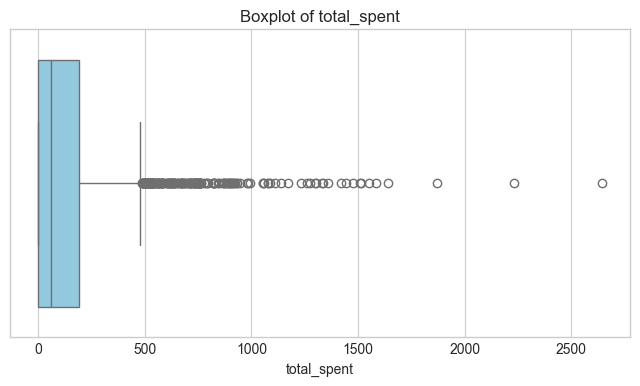

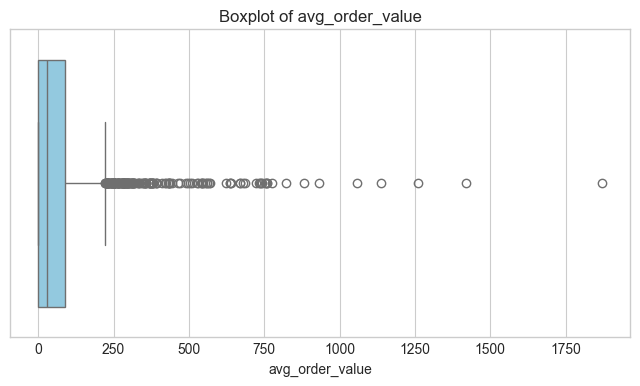

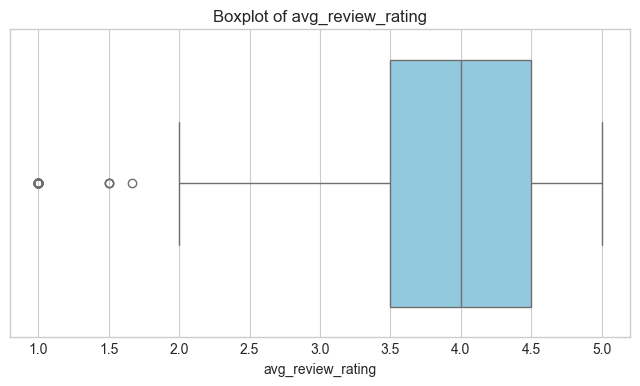

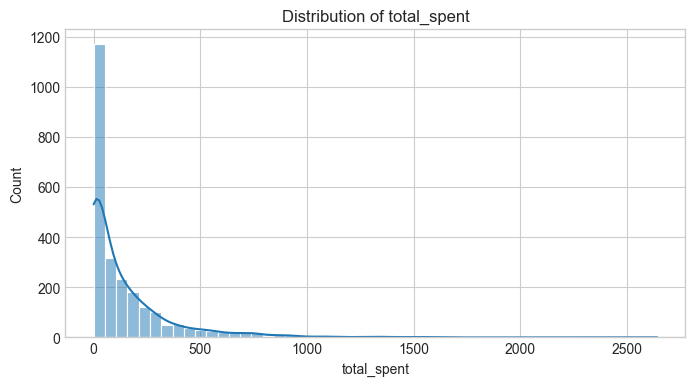

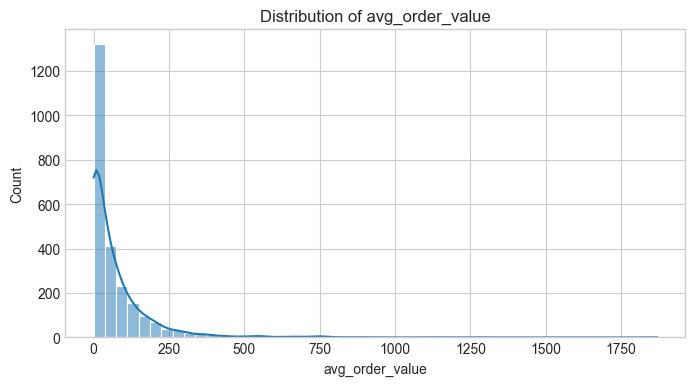

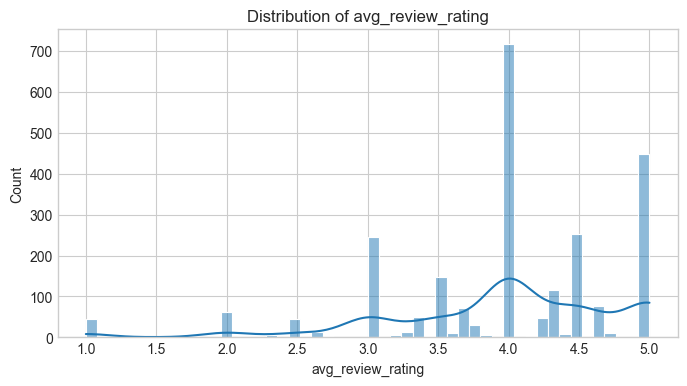

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# Select the 3 columns with outliers
outlier_cols = ['total_spent', 'avg_order_value', 'avg_review_rating']

# Create boxplots for each
for col in outlier_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

# Optional: histograms for deeper insight
for col in outlier_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


In [18]:
q_low, q_high = df['total_spent'].quantile([0.01, 0.99])
df = df[(df['total_spent'] >= q_low) & (df['total_spent'] <= q_high)]


In [19]:
q_low, q_high = df['avg_order_value'].quantile([0.01, 0.99])
df = df[(df['avg_order_value'] >= q_low) & (df['avg_order_value'] <= q_high)]


In [20]:
df.loc[df['avg_review_rating'] > 5, 'avg_review_rating'] = 5
df.loc[df['avg_review_rating'] < 0, 'avg_review_rating'] = 0


In [21]:
# Clean and standardize phone numbers

import re

def clean_phone(phone):
    if pd.isna(phone):
        return None
    # Keep only digits
    digits = re.sub(r'\D', '', str(phone))
    # Handle leading zeros and US-style examples
    if len(digits) == 10:
        return f"+1-{digits[:3]}-{digits[3:6]}-{digits[6:]}"
    elif len(digits) == 11 and digits.startswith('1'):
        return f"+{digits[0]}-{digits[1:4]}-{digits[4:7]}-{digits[7:]}"
    elif len(digits) > 11:
        # truncate or flag suspiciously long numbers
        return f"+{digits[:3]}-{digits[3:6]}-{digits[6:10]}"
    else:
        return None  # invalid or incomplete

# Apply to column
df['phone'] = df['phone'].apply(clean_phone)

# Preview before/after
df[['phone']].sample(10)


,phone
569,+749-785-2491
914,+001-212-9964
530,+1-943-191-0090
723,+207-266-2925
2102,+127-366-3256
2064,+001-459-2351
1049,+174-185-6302
2446,+462-201-6566
274,+001-576-5728
1261,+001-430-2178


In [22]:
# Quick overview
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nData sample:\n", df.head(5))

Shape: (2397, 30)

Columns:
 ['customer_id', 'total_spent', 'avg_order_value', 'total_orders', 'total_items', 'avg_discount', 'avg_review_rating', 'avg_seller_rating', 'avg_delivery_days', 'total_returns', 'return_ratio', 'total_previous_returns', 'is_prime_member', 'customer_tenure_days', 'last_order_date', 'first_order_date', 'recency_days', 'tenure_days', 'frequency', 'gender', 'region', 'age', 'registration_date', 'source', 'name', 'email', 'phone', 'income_segment', 'loyalty_status', 'is_active']

Data types:
 customer_id                       object
total_spent                      float64
avg_order_value                  float64
total_orders                       int64
total_items                        int64
avg_discount                     float64
avg_review_rating                float64
avg_seller_rating                float64
avg_delivery_days                float64
total_returns                      int64
return_ratio                     float64
total_previous_returns      

In [23]:
df.to_csv("../data/processed/clients.csv", index=False)
print("✅ clients.csv created successfully!")

✅ clients.csv created successfully!
